In [1]:
import pandas as pd
import numpy as np
import gudhi as gd
from gudhi.weighted_rips_complex import WeightedRipsComplex
from gudhi.point_cloud.timedelay import TimeDelayEmbedding
from gudhi.point_cloud.dtm import DistanceToMeasure
from gudhi.hera import wasserstein_distance
from gudhi.representations import PersistenceImage, BettiCurve
from sklearn.decomposition import PCA
import umap
from gudhi.representations.metrics import WassersteinDistance
import matplotlib.pyplot as plt
from matplotlib import cm
from sklearn.manifold import MDS
import os
from scipy import stats
from scipy.spatial.distance import cdist
#%matplotlib widget

In [2]:
datapath =".\\data\\timeseries\\Data_14122022\\"
data_gauss = np.loadtxt(datapath+"signal_Gauss.txt")
data_alpha18 = np.loadtxt(datapath+"signal_alpha1_8.txt")
data_alpha19 = np.loadtxt(datapath+"signal_alpha1_9.txt")



In [59]:
#dim * delay should roughly equal len(time_series)/numer_of_periods
dim = 3*833#417# half period
delay = len(data_gauss[0])//dim
print("delay", delay)
skip = 1#200#0#100
print(dim*delay)
print(len(data_gauss[0])/24)

tde = TimeDelayEmbedding(dim = dim, delay=delay, skip=skip)
point_clouds = tde.transform(np.concatenate((data_gauss,data_alpha18,data_alpha19)))

for i in range(0,len(point_clouds)):
    point_clouds[i] = point_clouds[i]-np.mean(point_clouds[i],1)[:, None]
    point_clouds[i] = point_clouds[i]/np.sqrt(np.sum(point_clouds[i]**2, 1))[:, None]

print(np.array(point_clouds).shape)
print(len(point_clouds[0]))

delay 20
49980
2083.3333333333335
(53, 40, 2499)
40


In [67]:
pds = []
weighted = True

for pc in point_clouds:
    if weighted:
        dist = cdist(pc,pc)
        dtm = DistanceToMeasure(5, dim = 10, q=2, metric="precomputed")
        r = dtm.fit_transform(dist)
        ac = WeightedRipsComplex(distance_matrix=dist,weights = 1/r)
    else:
        ac = gd.RipsComplex(pc)

    st = ac.create_simplex_tree(max_dimension = 2)
    st.compute_persistence()
    pd = st.persistence_intervals_in_dimension(1)
    pds.append(pd)


2.992193168343264 3.071586189441901


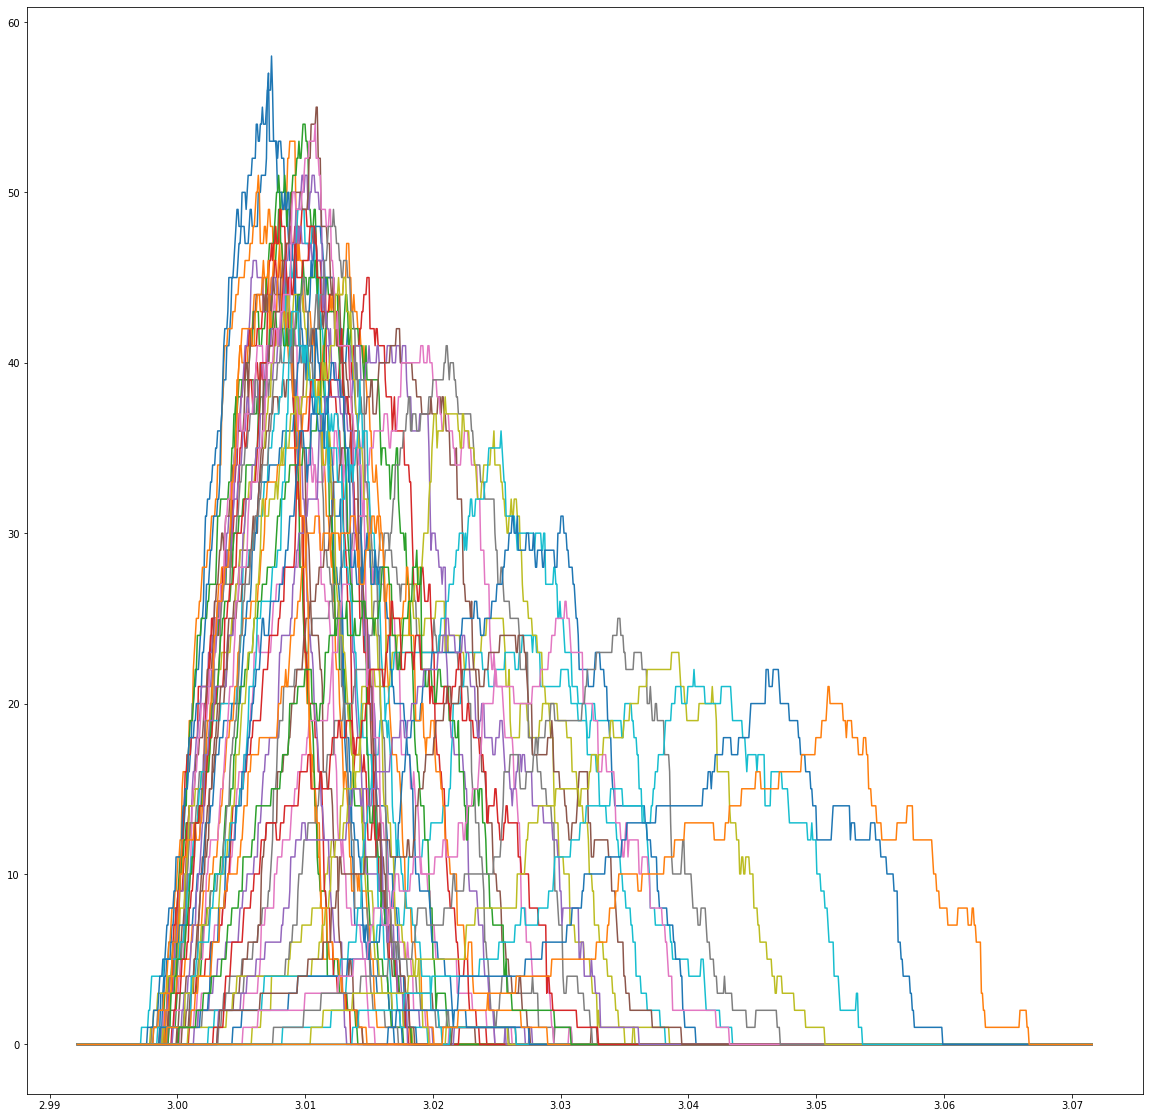

In [68]:
start = min([np.min(d) for d in pds])-0.005
end = max([np.max(d) for d in pds])+0.005
print(start,end)
x = np.linspace(start,end,1000)
bc = BettiCurve(predefined_grid=x)
betti_curves = bc.fit_transform(pds)

f,ax = plt.subplots(figsize=(20,20))
for i in range(0,len(pds)-1):
    ax.plot(x,betti_curves[i])
plt.show()

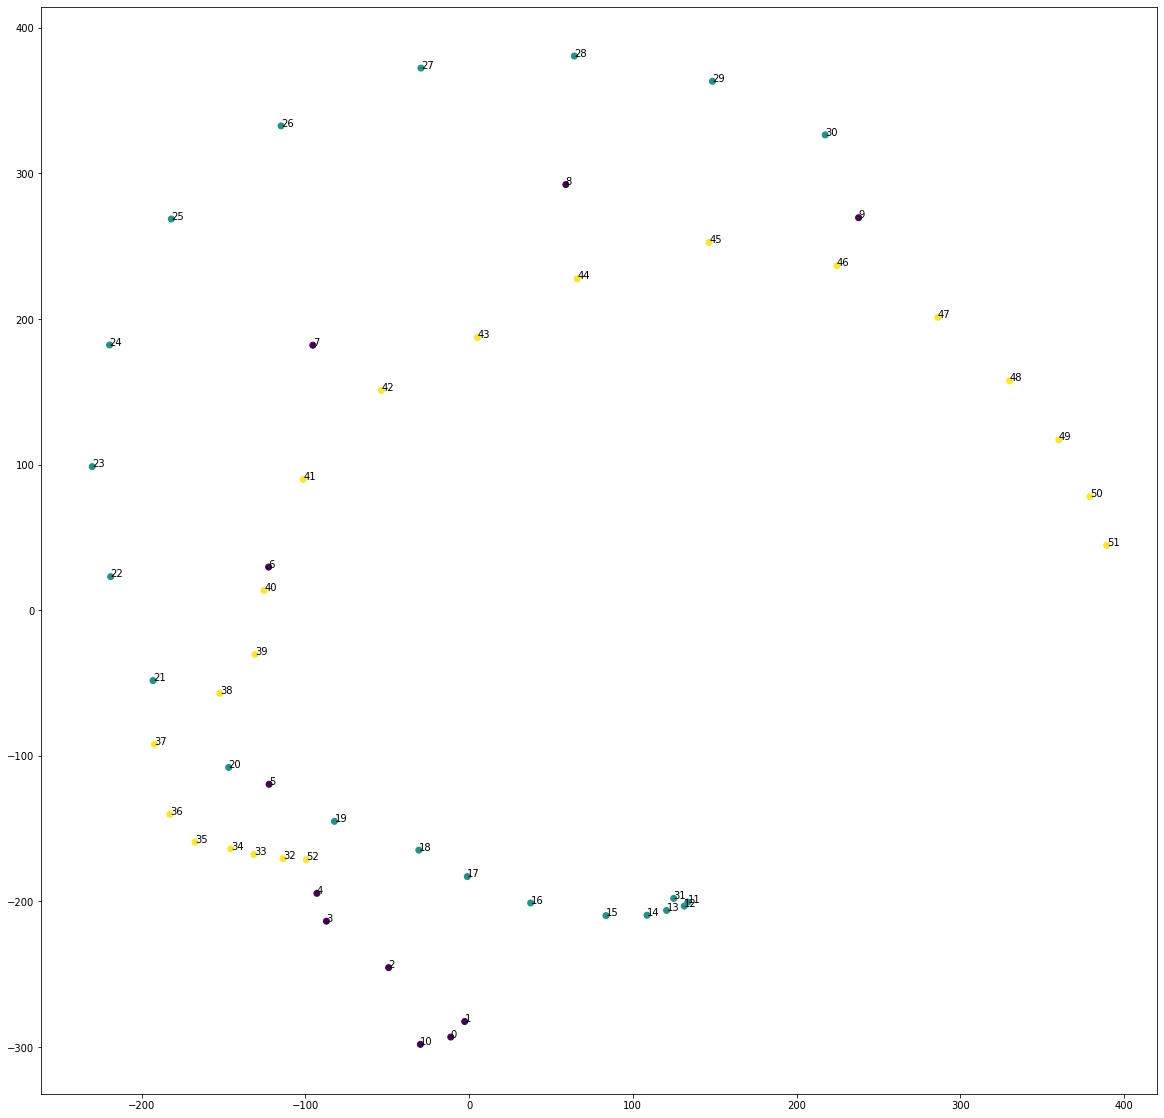

In [69]:
mds = MDS(n_components=2)
emb =mds.fit_transform(betti_curves)
f,ax = plt.subplots(figsize = (20,20))

t=np.array([0]*11+[1]*21+[2]*21)

ax.scatter(emb[:,0],emb[:,1], marker = "o", c=t, label="malfunctioning machine {}".format(i))
for i in range(0,len(emb)):
    
    ax.annotate("{}".format(i),(emb[i,0],emb[i,1]))

#ax.scatter(emb[-1,0],emb[-1,1], marker = "x", label="well-working machine")

#ax.legend()

#plt.savefig("data221214_alpha18_MDS-from-PI_density_dim{}_delay{}.pdf".format(dim, delay))
plt.show()

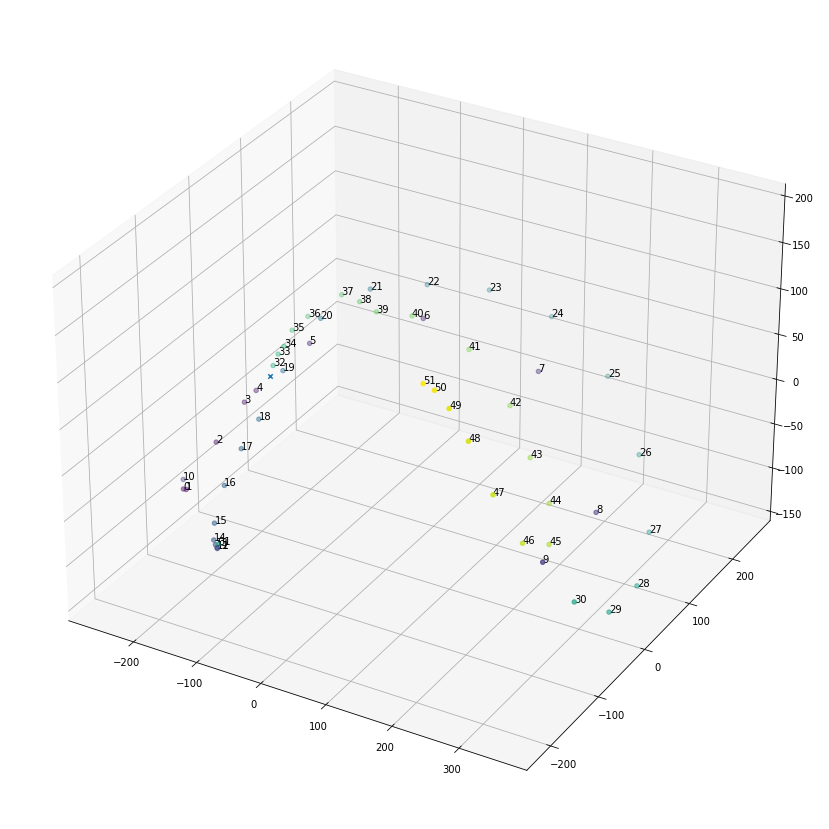

[0.59650928 0.23625287 0.08008152]


In [70]:

pca = PCA(n_components=3)
emb = pca.fit_transform(betti_curves)

fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot(projection='3d')

t=np.arange(len(emb)-1)

ax.scatter(emb[:-1,0],emb[:-1,1], emb[:-1,2], marker = "o", c=t, label="malfunctioning machine {}".format(i))
for i in range(0,len(emb)-1):    
    #ax.scatter(emb[i,0],emb[i,1], emb[i,2], marker = "o", c=t[i], label="malfunctioning machine {}".format(i))
    ax.text(emb[i,0],emb[i,1], emb[i,2],"{}".format(i))

ax.scatter(emb[-1,0],emb[-1,1], emb[-1,2], marker = "x", label="well-working machine")

#ax.legend()
#plt.savefig("data221214_alpha18_PCA-from-PI_dim{}_delay{}.pdf".format(dim, delay))
plt.show()
print(pca.explained_variance_ratio_)

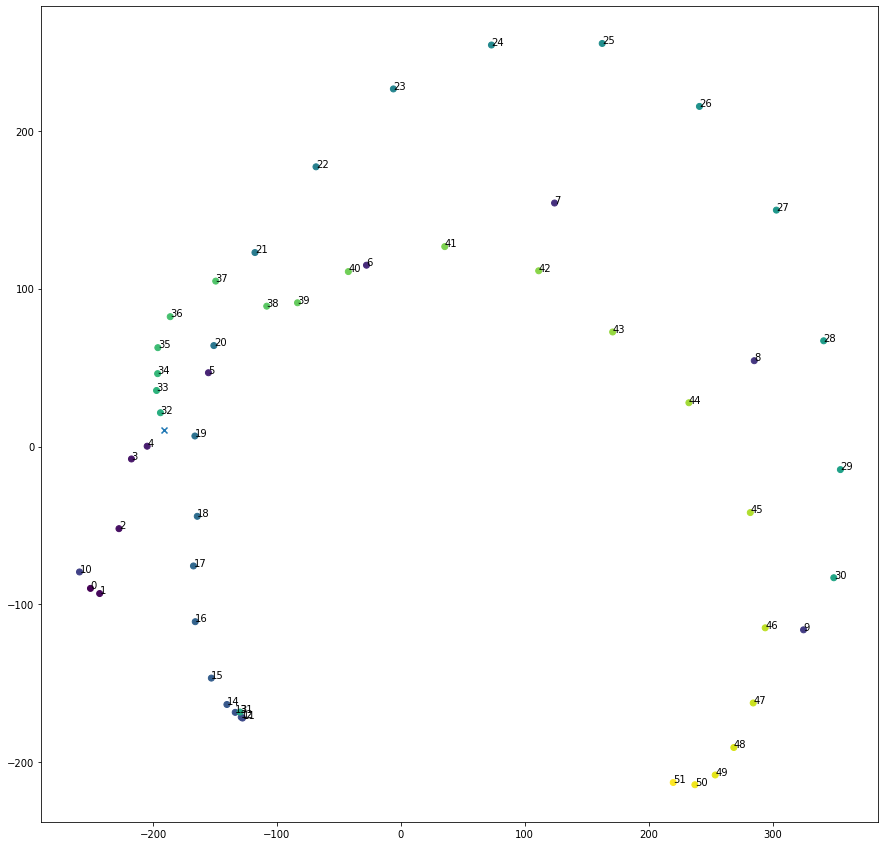

[0.59650928 0.23625287 0.08008152]


In [71]:
fig = plt.figure(figsize=(15,15))
ax = fig.add_subplot()

t=np.arange(len(emb)-1)

ax.scatter(emb[:-1,0],emb[:-1,1],  marker = "o", c=t, label="malfunctioning machine {}".format(i))
for i in range(0,len(emb)-1):    
    #ax.scatter(emb[i,0],emb[i,1], emb[i,2], marker = "o", c=t[i], label="malfunctioning machine {}".format(i))
    ax.text(emb[i,0],emb[i,1], "{}".format(i))

ax.scatter(emb[-1,0],emb[-1,1], marker = "x", label="well-working machine")

#ax.legend()
#plt.savefig("data221214_alpha18_PCA-from-PI_dim{}_delay{}.pdf".format(dim, delay))
plt.show()
print(pca.explained_variance_ratio_)

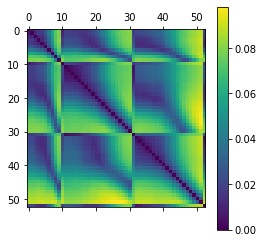

In [72]:
WD = gd.representations.WassersteinDistance(order=2, internal_p=2, n_jobs = -1)
#WD = gd.representations.BottleneckDistance(n_jobs = -1)
dist_matrix = WD.fit_transform(pds)
plt.matshow(dist_matrix)
plt.colorbar()
#plt.savefig("data221214_alpha18_W2_dim{}_delay{}.pdf".format(dim,delay))

c:\Users\Niklas\anaconda3\lib\site-packages\sklearn\manifold\_mds.py:419: UserWarning: The MDS API has changed. ``fit`` now constructs an dissimilarity matrix from data. To use a custom dissimilarity matrix, set ``dissimilarity='precomputed'``.
  warnings.warn("The MDS API has changed. ``fit`` now constructs an"


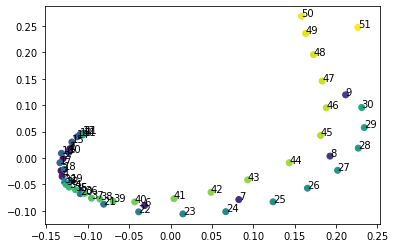

In [73]:
mds = MDS(n_components=2, metric = "precomputed")
emb =mds.fit_transform(dist_matrix)
f,ax = plt.subplots()
t=np.arange(len(emb)-1)

ax.scatter(emb[:-1,0],emb[:-1,1], marker = "o", c=t, label="malfunctioning machine {}".format(i))
for i in range(0,len(emb)-1):
    
    ax.annotate("{}".format(i),(emb[i,0],emb[i,1]))

ax.scatter(emb[-1,0],emb[-1,1], marker = "x", label="well-working machine")
#ax.legend()
#plt.savefig("data221214_alpha18_MDS-from-W2_dim{}_delay{}.pdf".format(dim, delay))
plt.show()